In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from google.colab import drive
import glob
from datetime import datetime

# Function to mount Google Drive
def mount_google_drive():
    """Connect to your Google Drive to access files"""
    print("Connecting to your Google Drive...")
    drive.mount('/content/drive')
    print("Connected successfully! Now we can access your Google Drive files.")

# Function to find CSV files for a country in a folder
def find_country_files(country, folder_path):
    """Find all CSV files related to a specific country in a folder"""
    # Search for files containing the country name
    country_files = glob.glob(f"{folder_path}/**/*{country}*.csv", recursive=True)
    print(f"Found {len(country_files)} files for {country} in {folder_path}")
    return country_files

# Function to read and process CSV files
def process_csv_files(country, files, indicators):
    """Read and process CSV files to extract indicator data"""
    print(f"Processing {len(files)} files for {country}...")

    # Create an empty DataFrame to store all indicators
    all_data = pd.DataFrame()

    # Process each file
    for file_path in files:
        file_name = os.path.basename(file_path)

        try:
            # Read the CSV file
            df = pd.read_csv(file_path)

            # Get date column (either 'date' or 'Date')
            date_col = None
            if 'date' in df.columns:
                date_col = 'date'
            elif 'Date' in df.columns:
                date_col = 'Date'
            else:
                # Look for columns containing 'date' or 'time'
                date_candidates = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower()]
                if date_candidates:
                    date_col = date_candidates[0]

            # If no date column found, skip this file
            if not date_col:
                print(f"  Warning: No date column found in {file_name}. Skipping.")
                continue

            # Convert date to datetime
            df[date_col] = pd.to_datetime(df[date_col])

            # Check if this file contains any of our indicators
            for indicator_name, column_name in indicators.items():
                # Check if indicator name is in the file name
                if indicator_name.lower() in file_name.lower() or column_name.lower() in file_name.lower():
                    # Find a column with the indicator value
                    value_col = None

                    # First, try to find a column matching the indicator name
                    for col in df.columns:
                        if indicator_name.lower() in col.lower() or column_name.lower() in col.lower():
                            value_col = col
                            break

                    # If that doesn't work, use the first numeric column
                    if not value_col:
                        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
                        if numeric_cols:
                            value_col = numeric_cols[0]

                    # If we found a value column, extract the data
                    if value_col:
                        # Create a new DataFrame with just date and value
                        indicator_df = df[[date_col, value_col]].copy()

                        # Rename columns
                        indicator_df.columns = ['date', column_name]

                        # If all_data is empty, use this as the base
                        if all_data.empty:
                            all_data = indicator_df
                        else:
                            # Otherwise, merge with existing data
                            all_data = pd.merge(all_data, indicator_df, on='date', how='outer')

                        print(f"  Added {indicator_name} data from {file_name}")
                        break
        except Exception as e:
            print(f"  Error processing {file_name}: {str(e)}")

    return all_data

# Function to standardize data to quarterly frequency
def standardize_to_quarterly(data):
    """Standardize data to quarterly frequency and fill missing values"""
    print("Standardizing data to quarterly frequency...")

    # If data is empty, return empty DataFrame
    if data.empty:
        return pd.DataFrame()

    # Set date as index
    data = data.set_index('date')

    # Resample to quarterly frequency (last value of the quarter)
    data = data.resample('QE').last()

    # Create a standardized date range from 2013 to 2025
    date_range = pd.date_range(
        start='2013-01-01',
        end='2025-12-31',
        freq='QE'  # Quarter End frequency
    )

    # Reindex the data to the standardized date range
    data = data.reindex(date_range)

    # Forward fill missing values
    data = data.ffill()

    # Reset index to get date as a column
    data = data.reset_index()
    data = data.rename(columns={'index': 'date'})

    return data

# Main function to process macroeconomic data
def process_macro_data():
    """Process macroeconomic data from Google Drive and save to CSV files"""
    # Step 1: Connect to Google Drive
    mount_google_drive()

    # Step 2: Define settings
    countries = ["Brazil", "India", "South_Africa"]

    # Define the mapping between indicator names and column names
    indicators = {
        'Real GDP': 'GDP',
        'CPI': 'CPI',
        'Unemployment': 'UNEMPLOYMENT',
        'Imports': 'IMPORTS',
        'Exports': 'EXPORTS',
        'Bond Yield': 'BOND_YIELDS',
        'Interest rate': 'INTEREST_RATE',
        'Exchange Rate': 'EXCHANGE_RATE'
    }

    # Extract folder IDs from the Google Drive links
    folder_ids = [
        "1_CUAJ9YHl9F_1QCgQ2YQxBSZAfVRhBeo",
        "1Xw0nLPt1bTSPmSdjBNx_B2KC1lIIzwI7",
        "1dDPZdvFZOp6d4TOW3NDBjhKxs2jvtlwm"
    ]

    # Create output directory
    output_dir = '/content/drive/MyDrive/processed_data'
    os.makedirs(output_dir, exist_ok=True)

    # Step 3: Process each country
    for country in countries:
        print(f"\nProcessing {country.upper()} data...")

        # Find files for this country
        all_country_files = []

        for folder_id in folder_ids:
            # Try different possible paths to the shared folder
            possible_paths = [
                f'/content/drive/MyDrive/shared_with_me/{folder_id}',
                f'/content/drive/Shareddrives/{folder_id}',
                f'/content/drive/MyDrive/Macro_Data/Brazil',
                f'/content/drive/MyDrive/Macro_Data/South_Africa',
                f'/content/drive/MyDrive/Macro_Data/India'
            ]

            for path in possible_paths:
                if os.path.exists(path):
                    country_files = find_country_files(country, path)
                    all_country_files.extend(country_files)

        # Process the files
        country_data = process_csv_files(country, all_country_files, indicators)

        # Standardize to quarterly frequency
        standardized_data = standardize_to_quarterly(country_data)

        # Save to CSV
        if not standardized_data.empty:
            output_path = os.path.join(output_dir, f"{country}_macro.csv")
            standardized_data.to_csv(output_path, index=False)
            print(f"Saved {country} data to {output_path}")
        else:
            print(f"No data found for {country}")

    print("\nData processing complete!")
    print("You can find the processed CSV files in the 'processed_data' folder in your Google Drive.")

# Run the script
if __name__ == "__main__":
    process_macro_data()



Connecting to your Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Connected successfully! Now we can access your Google Drive files.

Processing BRAZIL data...
Found 13 files for Brazil in /content/drive/MyDrive/Macro_Data/Brazil
Found 0 files for Brazil in /content/drive/MyDrive/Macro_Data/South_Africa
Found 0 files for Brazil in /content/drive/MyDrive/Macro_Data/India
Found 13 files for Brazil in /content/drive/MyDrive/Macro_Data/Brazil
Found 0 files for Brazil in /content/drive/MyDrive/Macro_Data/South_Africa
Found 0 files for Brazil in /content/drive/MyDrive/Macro_Data/India
Found 13 files for Brazil in /content/drive/MyDrive/Macro_Data/Brazil
Found 0 files for Brazil in /content/drive/MyDrive/Macro_Data/South_Africa
Found 0 files for Brazil in /content/drive/MyDrive/Macro_Data/India
Processing 39 files for Brazil...
  Added Imports data from Brazil Total Imports (2013-2023).csv
  Adde

<ipython-input-12-b0047388c4e8>:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])


  Added Exchange Rate data from Brazil Spot Exchange Rate to USD.csv
  Added Imports data from Brazil Total Imports (2013-2023).csv
  Added Exports data from Brazil Total Exports Quarterly (2013-2023).csv
  Added Real GDP data from Brazil Real GDP (Quarterly).csv
  Error processing Brazil Monthly Unemployment (2018-2024).csv: Out of bounds nanosecond timestamp: 30;;, at position 0
  Added Interest rate data from Brazil Interest Rates Quarterly (2013-2023).csv
  Added CPI data from Brazil CPI All Items Quarterly (2014-2024).csv
  Added Exchange Rate data from Brazil Spot Exchange Rate to USD.csv
  Added Imports data from Brazil Total Imports (2013-2023).csv
  Added Exports data from Brazil Total Exports Quarterly (2013-2023).csv
  Added Real GDP data from Brazil Real GDP (Quarterly).csv
  Error processing Brazil Monthly Unemployment (2018-2024).csv: Out of bounds nanosecond timestamp: 30;;, at position 0
  Added Interest rate data from Brazil Interest Rates Quarterly (2013-2023).csv
  A

<ipython-input-12-b0047388c4e8>:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])
<ipython-input-12-b0047388c4e8>:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])


Saved Brazil data to /content/drive/MyDrive/processed_data/Brazil_macro.csv

Processing INDIA data...
Found 0 files for India in /content/drive/MyDrive/Macro_Data/Brazil
Found 0 files for India in /content/drive/MyDrive/Macro_Data/South_Africa
Found 8 files for India in /content/drive/MyDrive/Macro_Data/India
Found 0 files for India in /content/drive/MyDrive/Macro_Data/Brazil
Found 0 files for India in /content/drive/MyDrive/Macro_Data/South_Africa
Found 8 files for India in /content/drive/MyDrive/Macro_Data/India
Found 0 files for India in /content/drive/MyDrive/Macro_Data/Brazil
Found 0 files for India in /content/drive/MyDrive/Macro_Data/South_Africa
Found 8 files for India in /content/drive/MyDrive/Macro_Data/India
Processing 24 files for India...
  Added Imports data from India International Imports (2013-2023).csv
  Added Exports data from India International Exports (2013-2023).csv
  Added Interest rate data from India Interest Rate 10-Year Bonds. (2014-2024)csv.csv
  Added Real

[*********************100%***********************]  1 of 1 completed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Folder already exists: /content/drive/My Drive/financial_info

Processing Brazil stock market data
Downloaded 148 months of data
Date range: 2013-01-01 00:00:00 to 2025-04-01 00:00:00
Saved processed data to /content/drive/My Drive/financial_info/brazil_stock.csv

Preview of processed data:
Price         Date    Close     High      Low     Open    Volume
Ticker                ^BVSP    ^BVSP    ^BVSP    ^BVSP     ^BVSP
0       2013-01-01  59761.0  63473.0  59114.0  60990.0  77083400
1       2013-02-01  57424.0  60496.0  55430.0  59764.0  71082200
2       2013-03-01  56352.0  59472.0  54648.0  57422.0  86585200


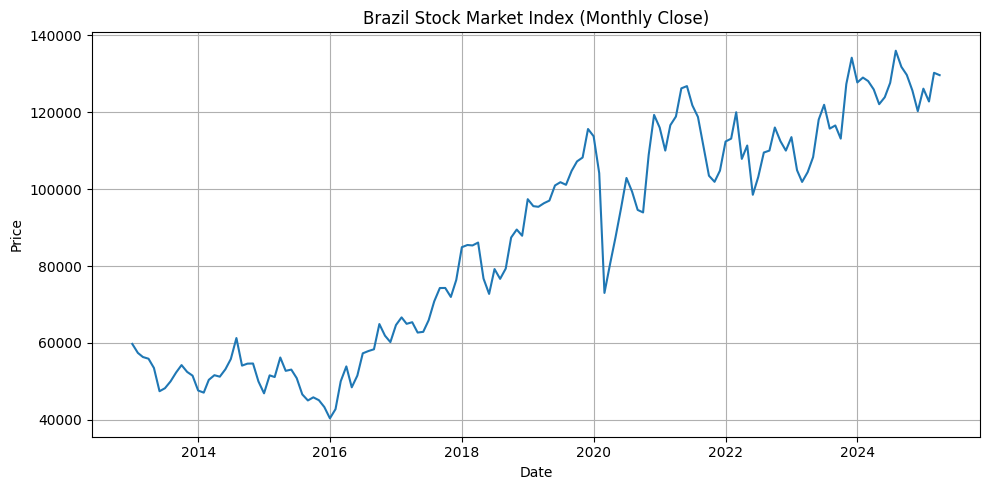

[*********************100%***********************]  1 of 1 completed


Processing India stock market data
Downloaded 148 months of data
Date range: 2013-01-01 00:00:00 to 2025-04-01 00:00:00
Saved processed data to /content/drive/My Drive/financial_info/india_stock.csv

Preview of processed data:
Price         Date    Close     High      Low     Open   Volume
Ticker                ^NSEI    ^NSEI    ^NSEI    ^NSEI    ^NSEI
0       2013-01-01  6034.75  6111.80  5940.60  5982.60  1293100
1       2013-02-01  5693.05  6052.95  5671.90  6040.95  3081200
2       2013-03-01  5682.55  5971.20  5604.85  5702.45  2879100


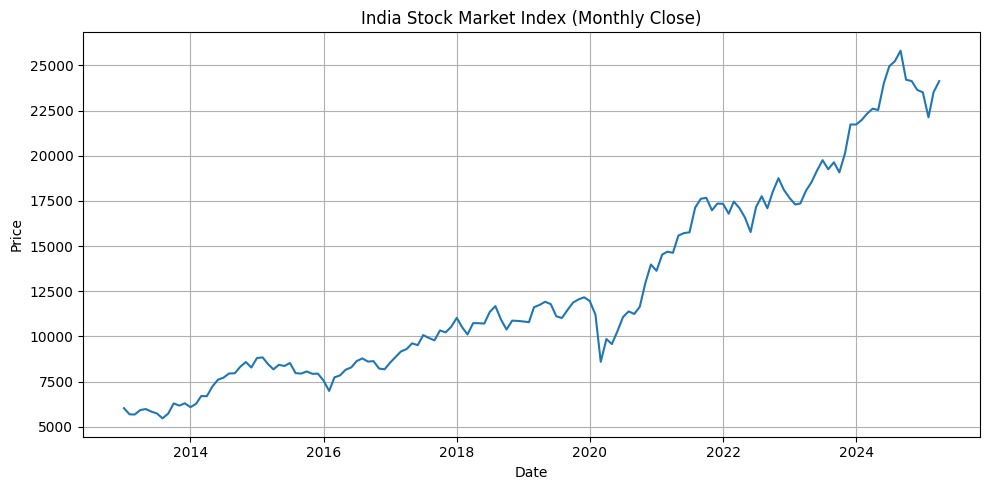

[*********************100%***********************]  1 of 1 completed


Processing South Africa stock market data
Downloaded 148 months of data
Date range: 2013-01-01 00:00:00 to 2025-04-01 00:00:00
Saved processed data to /content/drive/My Drive/financial_info/south_africa_stock.csv

Preview of processed data:
Price         Date  Close   High    Low   Open   Volume
Ticker                EZA    EZA    EZA    EZA      EZA
0       2013-01-01  40.03  43.34  39.28  42.79  8437300
1       2013-02-01  38.97  41.37  38.95  40.46  5940000
2       2013-03-01  38.58  40.16  37.77  39.33  7697300


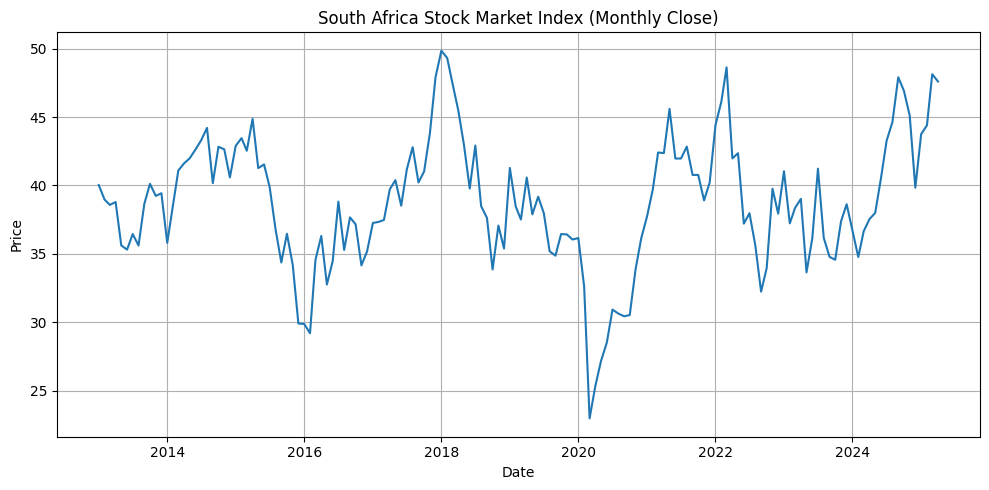


Processing complete!
All files have been saved to your Google Drive in the folder: /content/drive/My Drive/financial_info
If you still don't see the files, try refreshing your Google Drive in a new browser tab.


In [ ]:
# Improved Financial Market Data Collector
# This script downloads stock market data for Brazil, India, and South Africa
# and stores it in your Google Drive

# --- Install and import necessary libraries ---
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import os
from google.colab import drive

# --- Connect to Google Drive ---
drive.mount('/content/drive')

# --- Create a new folder for our files ---
# This will create a new folder called "financial_info" in your Google Drive
target_folder = '/content/drive/My Drive/financial_info'

# Check if folder exists, if not create it
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
    print(f"Created new folder: {target_folder}")
else:
    print(f"Folder already exists: {target_folder}")

# --- Define country stock indices (with correct tickers) ---
countries_data = {
    'brazil': {
        'index': '^BVSP',  # Bovespa index
        'name': 'Brazil'
    },
    'india': {
        'index': '^NSEI',  # Nifty 50 index
        'name': 'India'
    },
    'south_africa': {
        'index': 'EZA',  # iShares MSCI South Africa ETF
        'name': 'South Africa'
    }
}

# Define the time period (from 2013 to present)
start_date = '2013-01-01'
end_date = '2025-04-22'  # Today's date

# --- Download, process, and save data for each country ---
for country_code, info in countries_data.items():
    print(f"\n{'='*50}")
    print(f"Processing {info['name']} stock market data")
    print(f"{'='*50}")

    try:
        # Download stock data using yfinance
        print(f"Downloading data for {info['index']}...")
        stock_data = yf.download(
            info['index'],
            start=start_date,
            end=end_date,
            interval='1mo'  # Monthly data
        )

        if stock_data.empty:
            print(f"No data found for {info['name']}! Trying alternative ticker...")

            # Try alternative tickers for South Africa
            if country_code == 'south_africa':
                alternative_tickers = ['J203.JO', 'JALSH.JO', '^JALSH', '^SAALL']

                for ticker in alternative_tickers:
                    if ticker == info['index']:
                        continue  # Skip the one we already tried

                    print(f"Trying alternative ticker: {ticker}")
                    stock_data = yf.download(
                        ticker,
                        start=start_date,
                        end=end_date,
                        interval='1mo'
                    )

                    if not stock_data.empty:
                        print(f"Successfully found data with ticker: {ticker}")
                        break

        print(f"Downloaded {len(stock_data)} months of data")

        # Check if data was downloaded successfully
        if stock_data.empty:
            print(f"Failed to find data for {info['name']}!")
            continue

        # Basic information about the data
        print(f"Date range: {stock_data.index.min()} to {stock_data.index.max()}")

        # Clean the data
        # 1. Reset index to make Date a column
        stock_data = stock_data.reset_index()

        # 2. Convert Date column to standard format (as in the attached file)
        stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.strftime('%Y-%m-%d')

        # 3. Handle missing values with forward fill
        stock_data = stock_data.ffill()

        # 4. Convert numerical values to 2 decimal places
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
            if col in stock_data.columns:
                stock_data[col] = stock_data[col].round(2)

        # 5. Make sure Volume is integer (if it exists)
        if 'Volume' in stock_data.columns:
            stock_data['Volume'] = stock_data['Volume'].fillna(0).astype(int)

        # Save to CSV - fix the string/tuple error by ensuring all data is properly formatted
        output_file = f"{target_folder}/{country_code}_stock.csv"

        # The key fix: convert the dataframe to CSV directly, don't try to join column names
        stock_data.to_csv(output_file, index=False)
        print(f"Saved processed data to {output_file}")

        # Show a preview of the data
        print("\nPreview of processed data:")
        print(stock_data.head(3))  # Show just 3 rows to keep output clean

        # Plot closing prices
        plt.figure(figsize=(10, 5))
        plt.plot(pd.to_datetime(stock_data['Date']), stock_data['Close'])
        plt.title(f"{info['name']} Stock Market Index (Monthly Close)")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {info['name']}: {str(e)}")
        print("Let's try to explain the error:")

        if "expected str instance" in str(e):
            print("This error happens when the program tries to combine text with something that isn't text.")
            print("We've fixed this in our new code by directly saving the data without trying to join columns.")

        elif "404" in str(e):
            print("This error means the stock ticker symbol wasn't found on Yahoo Finance.")
            print("We've added alternative ticker symbols to try for South Africa.")

        else:
            print("This is an unexpected error. Try running the code again or check your internet connection.")

print("\nProcessing complete!")
print(f"All files have been saved to your Google Drive in the folder: {target_folder}")
print("If you still don't see the files, try refreshing your Google Drive in a new browser tab.")
